# Arbeiten mit realen Daten / Working with real data (Werkstoffe im Bauwesen)

Prof. Dr. David Kammer (Institute for Building Materials IfB) -- dkammer@ethz.ch -- v2024.09

This notebook serves two purposes. It is used for demonstration purposes during the lecture and as a theoretical basis for the lab session.

## Context

We are tasked with determining whether two boxes, labeled **A** and **B**, contain the same type of rubber bands. Since it is impractical to test every rubber band in the boxes, we will take a statistical approach by selecting a subset of rubber bands, known as a **sample**, from each box.

Our goal is to analyze the properties of these samples and, using statistical methods, evaluate whether the two boxes are likely to contain the same type of rubber bands. By measuring the stiffness (e.g. via secant modulus) of the rubber bands and comparing the results, we aim to draw conclusions about the entire population of rubber bands in both boxes based on our sampled data.

## Preliminaries

In this section, we setup a few modules and variables that will be used for the analysis of the data.

We will use the following Python libraries for data handling, statistical analysis, and visualization:

- **[Pandas](https://pandas.pydata.org/)**: Pandas is a powerful library for data manipulation and analysis. It allows us to easily read data from various file formats (such as CSV or Excel), organize the data into DataFrames, and perform efficient data operations. We'll use Pandas to load and preprocess the material testing data.
  
- **[SciPy (specifically `scipy.stats`)](https://scipy.org/)**: SciPy provides a range of scientific and mathematical tools, and its `stats` module is particularly useful for performing statistical analysis. We will use it to compute the mean, standard deviation, confidence intervals, and conduct hypothesis tests, which are critical for material testing and analysis.

- **[Matplotlib](https://matplotlib.org/)**: Matplotlib is a widely used library for creating static, animated, and interactive visualizations in Python. We'll use it to plot our data and visualize statistical results, such as confidence intervals and error bars, making it easier to interpret and communicate findings.

By combining these libraries, we can efficiently load data, perform statistical analysis, and visualize the results, providing a comprehensive and practical approach to material testing in engineering.

In [1]:
# Importing the necessary libraries
import pandas as pd          # For data manipulation and reading data from files
import scipy.stats as stats   # For statistical analysis
import matplotlib.pyplot as plt  # For data visualization

In [2]:
# some configurations
colors = ['#003f5c', '#ffa600']

## User-Defined Input

In this section, we define all the user input variables that will be used throughout the notebook. By organizing all user inputs in one place at the beginning, we ensure that the notebook is easy to update and maintain. This approach allows users to quickly modify key parameters, such as the dictionary of file names or the force applied during material testing, without needing to search through the entire notebook.

Using a dictionary to store the file names is better than a list because it allows for clearer association between the material names and their corresponding datasets. With a dictionary, each material name becomes a key, making it easy to identify and access the relevant data without relying on index positions, which can be error-prone in a list. This structure enhances code readability and maintainability, as it ensures that results are always tied to the correct material, avoiding confusion when dealing with multiple datasets. Additionally, it simplifies future operations like plotting or analysis by allowing direct access to each material's data by name.

In [3]:
# Define file paths
file_paths = {
    'Material A': '2024_box_a(1).xlsx',
    'Material B': '2024_box_b(1).xlsx'
}

In [4]:
# Compute the applied force based on the weight 
mass = 691 # [grams]
gravity = 9.81 # acceleration due to gravity [m/s²]
applied_force = mass / 1000 * gravity # force [N]

print(f"Applied Force: {applied_force} N")

Applied Force: 6.77871 N


## Defining Functions for Reusable Tasks

In this section, we will define functions to perform well-defined tasks, such as loading data, calculating statistical measures, or plotting results. Functions allow us to organize our code into reusable units, which can be applied multiple times without rewriting the same code. For example, when testing two different sets of materials, we may have two separate files. Instead of repeating the same code for both datasets, we can apply the same function to each file, making the process efficient and clean.

#### Why Avoid Code Duplication?

Code duplication can lead to several issues:
- **Inconsistency**: If we need to update the code, having the same logic repeated in multiple places increases the chance of errors or missing an update.
- **Readability**: Duplicated code makes it harder to understand the notebook's structure and purpose, especially for others reading or reviewing your work.
- **Maintainability**: Avoiding duplication makes it easier to maintain the notebook, as you only need to make changes in one place rather than across multiple sections.

#### Why Define Functions Early in the Notebook?

By defining functions at the beginning, we ensure that these building blocks are ready to use throughout the notebook. It helps structure the notebook logically, making it easier to follow and ensuring that repetitive tasks, such as reading data, calculating the mean, or plotting, can be performed consistently. This approach improves code efficiency, readability, and reusability, allowing us to focus more on the analysis rather than repeating the same steps manually.

### Reading and Cleaning Data from Files

The function `read_and_clean_file()` is designed to automate the process of reading and cleaning material testing data from an Excel file. Here’s what this function does:

- **Input Parameters**: The function takes in two arguments: the file path (`file_path`) to the Excel file and the names of the columns (`initial_col` and `final_col`) containing the initial and final measurements. These columns represent the data we are interested in analyzing.
  
- **Reading Data**: It reads the Excel file using Pandas' `read_excel()` function, loading the data into a DataFrame for easy manipulation and analysis.
  
- **Cleaning Data**: The function converts the `initial_col` and `final_col` to numeric values, handling any non-numeric entries (such as text or empty cells) by replacing them with `NaN` (missing values). This ensures that only valid numeric data is processed.
  
- **Filtering Data**: It then filters out any rows that contain missing values (`NaN`) in either of these two columns, ensuring that the dataset used for analysis is clean and complete.

- **Returning Cleaned Data**: Finally, the function returns a cleaned DataFrame with only the relevant columns and valid data, ready for further statistical analysis.

This function helps streamline the process of loading and cleaning datasets, ensuring that we have consistent, error-free data for analysis without manually repeating the same steps for different files.


In [5]:
def read_and_clean_file(file_path, initial_col='initial length', final_col='final length'):
    # Read the Excel file
    data = pd.read_excel(file_path)
    
    # Convert columns to numeric, setting errors='coerce' to replace non-numeric values with NaN
    data[initial_col] = pd.to_numeric(data[initial_col], errors='coerce')
    data[final_col] = pd.to_numeric(data[final_col], errors='coerce')
    
    # Filter out rows with NaN values
    cleaned_data = data[[initial_col, final_col]].dropna()
    
    return cleaned_data


### Computing Stiffness from Material Data

The function `compute_stiffness()` calculates the stiffness of a material based on the initial and final lengths of the sample and a given applied force. Here’s what this function does:

- **Input Parameters**: 
  - The function takes in three arguments: 
    - `df`: A DataFrame containing the cleaned data with initial and final length measurements.
    - `force`: The applied force ($F$) during the material testing, assumed to be constant.
    - `initial_col` and `final_col`: The names of the columns that contain the initial ($l_i$) and final ($l_f$) length data.

- **Calculating Length Difference**: 
  - The function calculates the difference between the final and initial lengths for each sample $\Delta l = l_f - l_i$. This difference (`length_diff`) represents the material’s deformation, which is needed to compute the stiffness.

- **Computing Stiffness**:
  - Stiffness is defined as the ratio of the applied force to the deformation (length difference): $K = F/ \Delta l$. The function creates a new column, `stiffness`, where each value is calculated by dividing the applied force by the length difference for each sample.
  - To avoid division by zero (which would occur if any length difference is 0), the function replaces zero values in `length_diff` with `pd.NA` (Pandas' representation of missing values), ensuring that the division is safe and valid. When a division by `pd.NA` occurs, the result will also be `pd.NA`.

- **Returning the Data**: 
  - The function returns the updated DataFrame with two additional columns: `length_diff` (the calculated deformation) and `stiffness` (the calculated stiffness for each sample).

This function provides a simple and reusable way to compute stiffness for a set of material samples, ensuring that all calculations are performed consistently and safely, even in cases where no deformation is detected (i.e., length difference = 0).

In [6]:
def compute_stiffness(df, force, initial_col='initial length', final_col='final length'):
    # Calculate the difference between final length and initial length
    df['length_diff'] = df[final_col] - df[initial_col]
    
    # Compute stiffness
    # Avoid division by zero by checking for length_diff != 0
    df['stiffness'] = force / df['length_diff'].replace(0, pd.NA)
    
    return df

## Loading Data and Computing Stiffness

Now that we have defined our functions and inputs, we are ready to load the material testing data and compute the relevant quantities, such as stiffness. 

In this step, we will:
1. **Process and Clean the Files**: For each file in the dictionary of file names (`file_paths`), we will use the `read_and_clean_file()` function to load the data, clean it, and ensure only valid numeric values are used.
2. **Compute Stiffness**: After cleaning the data, we will calculate the stiffness for each sample using the `compute_stiffness()` function, which applies the provided force and calculates stiffness based on the change in length of each sample.
3. **Store Results**: We will store the cleaned and processed data, including the computed stiffness values, in a dictionary (`data_frames`). This allows us to easily access the results for further analysis or visualization later in the notebook.

This process ensures that the data is fully prepared for statistical analysis and that the computations are handled efficiently for each dataset.

In [7]:
# Process and clean files, then compute stiffness
data_frames = {}
for material_name, file_path in file_paths.items():
    cleaned_data = read_and_clean_file(file_path)
    stiffness_data = compute_stiffness(cleaned_data, force=applied_force)
    data_frames[material_name] = stiffness_data  # Store results in the dictionary

In [8]:
# Display the first few rows of each DataFrame in the dictionary
for material_name, df in data_frames.items():
    print(f"Data for {material_name} with stiffness:\n", df.head(), "\n")

Data for Material A with stiffness:
    initial length  final length  length_diff  stiffness
3           120.0         210.0         90.0   0.075319
4           120.0         175.0         55.0   0.123249
5           125.0         285.0        160.0   0.042367
6           120.0         212.0         92.0   0.073682
7           120.0         210.0         90.0   0.075319 

Data for Material B with stiffness:
    initial length  final length  length_diff  stiffness
0           125.0         210.0         85.0   0.079750
1           120.0         205.0         85.0   0.079750
2           120.0         205.0         85.0   0.079750
3           120.0         168.0         48.0   0.141223
4           113.0         128.0         15.0   0.451914 



## Histogram Plot of Stiffness Values

### What is a histogram?

A **histogram** is a graphical representation of the distribution of a dataset. It divides the range of data into intervals (or "bins") and displays how many data points fall into each bin. The height of each bar in the histogram indicates the frequency (or count) of data points within that specific range of values.

In the context of material stiffness:

- The **x-axis** represents the stiffness values measured during testing.
- The **y-axis** represents the number of occurrences (or frequency) of those stiffness values in the dataset.

### What a histogram can tell us

A **histogram** is a useful tool for visualizing the distribution of the stiffness values for each material. By plotting the frequency of different stiffness values, we can gain insights into how the data is spread across the range of measurements. Specifically, a histogram allows us to:

- Observe the **shape** of the data distribution (e.g., whether it is normal, skewed, or multimodal).
- Identify the **range** of stiffness values and how frequently each value occurs.
- Detect any potential **outliers** or unusual patterns in the data.
  
In this context, the histogram helps us understand how consistent or variable the stiffness measurements are within each material. It also gives a quick visual comparison of the stiffness distributions across different materials.

### Code for Plotting Histograms

#### Why using matplotlib

We use the [`matplotlib`](https://matplotlib.org/) library (importing the submodule `pyplot` as `plt`) for plotting because it provides a powerful and flexible tool for creating a wide range of visualizations, including histograms, scatter plots, and error bars. It allows us to customize plots to suit our needs, making it ideal for clearly visualizing statistical data, such as the stiffness values of materials. Additionally, `matplotlib` integrates smoothly with Python and other libraries like `pandas`, making it a natural choice for data analysis in Jupyter notebooks.

#### Necessary Elements for Plotting a Histogram
To create the histograms, the following key steps are used:

- `plt.hist()`: This function is used to plot the histogram. It takes the stiffness values, splits them into **bins**, and displays the frequency of the values in each bin.
- **Bins**: We specify the number of bins (20 in this case) to divide the range of stiffness values into intervals.

This setup provides the core structure of the histogram, allowing us to visualize the distribution of stiffness for each material.

#### Additional Formatting
Any graph should include axes labels:

- **X-axis** (`plt.xlabel()`): Represents the stiffness values.
- **Y-axis** (`plt.ylabel()`): Represents the frequency of those stiffness values.

For enhanced clarity and aesthetics, we include additional formatting options:

- **Colors**: Each material’s histogram is assigned a different color (`color=colors[i]`) to distinguish between them.
- **Alpha (Opacity)**: We set the transparency of the bars (`alpha=0.3`), which helps improve the visual clarity of potentially overlapping bars.
- **Edge color**: The edges of the bars are outlined in black (`edgecolor='black'`) to make them more distinct.
- **Titles** (`plt.title()`): Each subplot has a title specifying the material name.
- **Tight Layout** (`plt.tight_layout()`): This ensures the subplots are well-spaced without overlapping.

These formatting options make the histograms more readable and visually appealing, while still focusing on the data.

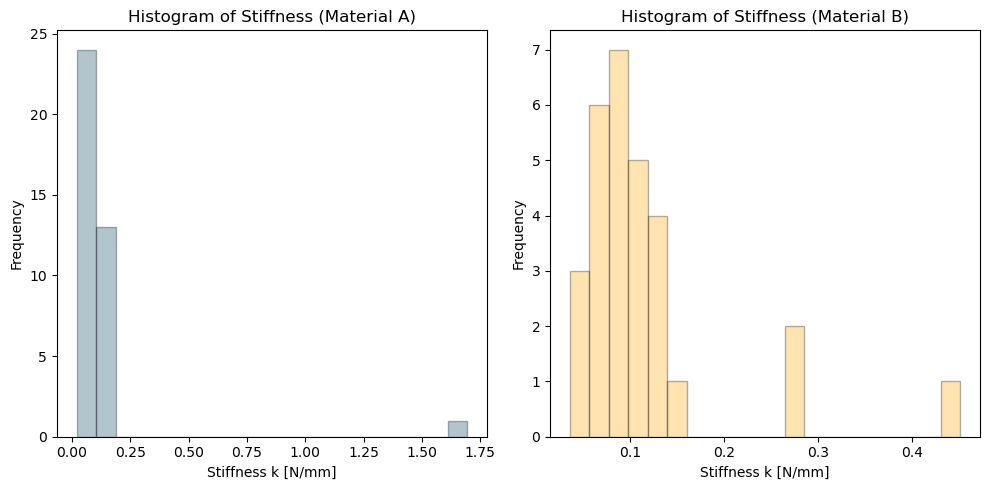

In [9]:
# Plot histograms for stiffness values with specified colors, alpha, and labels
plt.figure(figsize=(10, 5))

for i, (material_name, df) in enumerate(data_frames.items()):
    plt.subplot(1, len(data_frames), i + 1)
    plt.hist(df['stiffness'].dropna(), bins=20, edgecolor='black', color=colors[i], alpha=0.3)
    plt.title(f'Histogram of Stiffness ({material_name})')
    plt.xlabel('Stiffness k [N/mm]')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Statistical Analysis of Material Stiffness

In material testing, statistical metrics like the **mean** and **standard deviation** are essential for summarizing and interpreting data. 

- The **mean** provides a measure of central tendency, giving us the average stiffness of the material based on the data collected during testing. It reflects the typical behavior of the material under the applied conditions.

- The **standard deviation** quantifies the spread or variability of the data around the mean. A smaller standard deviation indicates that the stiffness values are tightly clustered near the mean, suggesting consistent behavior. A larger standard deviation suggests more variability in the material's performance.

Together, the mean and standard deviation provide valuable insights into the material’s performance, helping us assess its reliability and compare it with other materials.

#### How to compute the mean and standard deviation in DataFrames

We used a loop to iterate over each material in the `data_frames` dictionary, which contains the cleaned data for each material. We performed the following steps:

1. **Initialize Dictionaries**: We created two empty dictionaries, `means` and `std_devs`, to store the computed mean and standard deviation for each material.

2. **Compute Mean and Standard Deviation**: For each material, we accessed the 'stiffness' column in its DataFrame and used Pandas' built-in methods `.mean()` and `.std()` to compute the mean and standard deviation, respectively.

    - `df['stiffness'].mean()`: Calculates the average stiffness value for the material.
    - `df['stiffness'].std()`: Calculates the standard deviation of the stiffness values, which measures the spread of the data around the mean.


In [10]:
# Initialize dictionaries to store the mean and standard deviation values
means = {}
std_devs = {}

# Compute the mean and standard deviation for each material's stiffness
for material_name, df in data_frames.items():
    means[material_name] = df['stiffness'].mean()
    std_devs[material_name] = df['stiffness'].std()

#### Alternative Methods

While Pandas provides convenient methods for computing statistical measures directly on DataFrame columns, we can also use functions from the `scipy.stats` module or other libraries like NumPy. Here's how you could achieve the same calculations using these alternatives:

##### Using `scipy.stats`

- **Compute Mean**: You can use `scipy.stats.tmean()` to compute the mean of the data.

    ```python
    from scipy import stats

    # Compute the mean using scipy.stats
    for material_name, df in data_frames.items():
        means[material_name] = stats.tmean(df['stiffness'])
    ```

- **Compute Standard Deviation**: Use `scipy.stats.tstd()` to calculate the standard deviation.

    ```python
    # Compute the standard deviation using scipy.stats
    for material_name, df in data_frames.items():
        std_devs[material_name] = stats.tstd(df['stiffness'])
    ```

    **Note**: The `tmean()` and `tstd()` functions are especially useful when you need to compute the mean and standard deviation while excluding values outside a specific range (trimming). In our case, since we are considering all data points, these functions will yield the same results as the standard calculations.

##### Using NumPy

- **Compute Mean**: Utilize `numpy.mean()` to calculate the mean.

    ```python
    import numpy as np

    # Compute the mean using NumPy
    for material_name, df in data_frames.items():
        means[material_name] = np.mean(df['stiffness'])
    ```

- **Compute Standard Deviation**: Use `numpy.std()` with `ddof=1` to calculate the sample standard deviation.

    ```python
    # Compute the standard deviation using NumPy
    for material_name, df in data_frames.items():
        std_devs[material_name] = np.std(df['stiffness'], ddof=1)
    ```

    - The `ddof=1` parameter ensures that we are calculating the **sample standard deviation**, which is the same as what Pandas' `.std()` computes (unbiased estimator).


#### Why Consider Alternative Methods?

Using `scipy.stats` or `NumPy` functions might be preferred in certain situations:

- **Flexibility**: These libraries offer additional parameters and options, such as specifying the degrees of freedom or handling missing data in different ways.

- **Performance**: When working with large datasets or arrays, NumPy functions can be faster since they are optimized for numerical computations.

- **Consistency**: If the rest of your statistical analysis heavily relies on `scipy.stats`, using its functions for basic statistics can make your code more consistent.

- **Advanced Statistical Functions**: `scipy.stats` provides a wide range of statistical functions beyond basic mean and standard deviation, which might be necessary for more complex analyses.

#### Plotting the Mean and Standard Deviation

In this section, we visualize the **mean stiffness** for each material along with their corresponding **standard deviations** using error bars. This plot helps us compare the average stiffness values and understand the variability within each material.

**Necessary Elements for Plotting:**

- **Compute the Mean and Standard Deviation**: We use the previously calculated mean (`mean_value`) and standard deviation (`std_value`) for each material's stiffness.

- **Plot Mean Values with Error Bars**: We utilize the `plt.errorbar()` function from the `matplotlib` library to plot the mean values with error bars representing the standard deviation. The key arguments used in `plt.errorbar()` are:

    - **x**: The positions on the x-axis, which are the material names (`material_name`).
    - **y**: The mean stiffness values for each material (`mean_value`).
    - **yerr**: The error values in the y-direction, which are the standard deviations (`std_value`).

By providing these arguments, `plt.errorbar()` plots each material's mean stiffness as a point on the x-axis, with vertical error bars extending above and below the point to represent one standard deviation from the mean. This visual representation helps us understand both the central tendency and the variability of the stiffness measurements for each material.


#### Additional Formatting

For enhanced clarity and aesthetics, we include additional formatting options:

- **Dot Color**: Each mean value is plotted as a dot with a specific color corresponding to the material (`color=colors[i]`). This helps differentiate the materials visually.
  
- **Error Bar Color**: The error bars are colored black (`ecolor='black'`) to ensure they stand out against the colored dots.
  
- **Error Bar Caps**: Setting the cap size (`capsize=10`) adds caps to the ends of the error bars, making them more distinct and easier to read.
  
- **Marker Size**: Increasing the marker size (`markersize=8`) makes the mean value dots more visible.
  
- **Figure Size**: Adjusting the figure size (`plt.figure(figsize=(4, 3))`) ensures the plot fits well within the notebook and maintains an appropriate aspect ratio.

- **Figure Title**: A title is added to the figure (`plt.title('Mean & Standard Deviation')`)
  
- **Axis Labels and Ticks**: 
  - The y-axis label (`plt.ylabel('Mean Stiffness k [N/mm]')`) indicates the metric and its units.
  - The x-ticks are set to display the material names clearly without rotation (`plt.xticks(rotation=0)`).
  
- **Layout Adjustment**: Using `plt.tight_layout()` automatically adjusts subplot parameters to prevent overlap between plot elements.

These formatting choices improve the clarity and aesthetics of the plot, making it easier to interpret the data and compare the materials effectively.

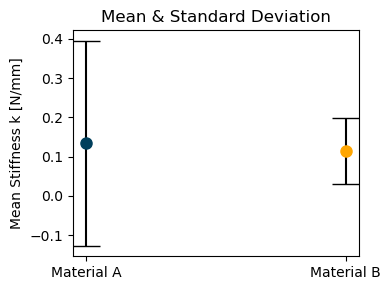

In [11]:
# Plot mean values as dots with black error bars
plt.figure(figsize=(4, 3))

# Loop through each material and plot its mean with its respective color
for i, (material_name, mean_value) in enumerate(means.items()):
    std_value = std_devs[material_name]
    plt.errorbar(material_name, mean_value, yerr=std_value, fmt='o', 
                 color=colors[i], ecolor='black', capsize=10, markersize=8, linestyle='None')

# Customize the plot
plt.title('Mean & Standard Deviation')
plt.ylabel('Mean Stiffness k [N/mm]')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Interpreting the Sample Mean and Standard Deviation

The **mean** and **standard deviation** we calculated earlier provide important information about the sample of rubber bands we tested, but they have limitations when it comes to drawing conclusions about the entire population of rubber bands in each box.

- The **sample mean** gives us an estimate of the central tendency of the stiffness for the tested rubber bands. It reflects the average stiffness of the sample but does not guarantee that the mean stiffness of the entire box (the population) will be exactly the same.
  
- The **sample standard deviation** tells us how spread out the stiffness values are in the sample. It provides an indication of variability among the tested rubber bands, but it does not necessarily represent the variability of the entire box.

#### What the Mean and Standard Deviation Do Not Tell Us

While the mean and standard deviation are useful, they do not account for the fact that we are working with a **sample** and not the entire population. Therefore, these values do not directly provide us with the confidence that the sample accurately reflects the population as a whole. 

To gain insight into how well our sample represents the population, we need to compute the **standard error** and, later, confidence intervals. These additional statistical measures help us understand the reliability and precision of our sample estimates when making inferences about the entire population of rubber bands in each box.


## Standard Error

The **standard error** (SE) is a measure of how much variability we can expect in the sample mean if we were to take repeated samples from the population. It tells us how precise our sample mean is as an estimate of the true population mean.

Mathematically, the standard error is calculated as:


$$
SE = \frac{\sigma}{\sqrt{n}}
$$

Where:
- **σ** is the sample standard deviation (the variability of the sample),
- **n** is the sample size.

### Why We Compute the Standard Error

In this analysis, we compute the standard error to understand how precise our sample mean stiffness values are as estimates of the true stiffness values for all the rubber bands in the boxes. 

Since we are only testing a subset of the rubber bands from each box (the **sample**), the standard error helps us evaluate how accurately these tested rubber bands represent the entire box (the **population**). A smaller standard error means the sample mean is a more reliable estimate of the population mean, while a larger standard error suggests more uncertainty.


### Code for Computing and Printing the Standard Error

To compute the **standard error** (SE) for the stiffness values of each material, we used the `scipy.stats.sem()` function, which calculates the standard error of the mean based on the sample standard deviation and the sample size.

Here’s how the code works:

1. **Initialize a Dictionary**: We created a dictionary `standard_errors` to store the standard error values for each material. This structure allows us to easily map each material to its respective standard error.

2. **Compute the Standard Error**: For each material in the `data_frames` dictionary, we used the `stats.sem()` function to calculate the standard error of the 'stiffness' column. The `dropna()` method was applied to exclude any missing values (`NaN`), ensuring that only valid data points are used in the calculation.

3. **Print the Results**: After computing the standard error for each material, we looped over the `standard_errors` dictionary and printed the results in a readable format, displaying the standard error for each material.

In [12]:
# Initialize a dictionary to store the standard error values
standard_errors = {}

# Compute the standard error for each material's stiffness
for material_name, df in data_frames.items():
    standard_errors[material_name] = stats.sem(df['stiffness'].dropna())

# Print the standard errors for each material
for material_name, std_error in standard_errors.items():
    print(f"Standard Error of Stiffness for {material_name}: {std_error:.4f}")

Standard Error of Stiffness for Material A: 0.0425
Standard Error of Stiffness for Material B: 0.0157


## Confidence Interval

A **confidence interval** provides a range of values within which we can be reasonably certain that the true population mean lies, based on our sample data. Unlike the mean, which gives a single estimate, the confidence interval accounts for the uncertainty that comes with sampling only a subset of the population.

### Definition of the Confidence Interval

The confidence interval is constructed around the sample mean, extending above and below it by a certain margin. This margin is determined by the **standard error** and the desired level of confidence (commonly 95%). For a 95% confidence interval, we can be reasonably confident that the true population mean lies within this range 95% of the time if we were to take repeated samples.

#### Confidence Interval Using the **z-distribution** (large sample size):

$$
\text{Confidence Interval} = \text{Sample Mean} \pm z^* \times SE
$$

Where:
- **Sample Mean** is the average stiffness of the tested rubber bands,
- **SE** is the standard error,
- $z^*$ is the critical value from the **z-distribution** (normal distribution), which corresponds to the desired confidence level (e.g., for 95%, $ z^* \approx 1.96 $).

#### Confidence Interval Using the **t-distribution** (small sample size):

$$
\text{Confidence Interval} = \text{Sample Mean} \pm t^* \times SE
$$

Where:
- **Sample Mean** is the average stiffness of the tested rubber bands,
- **SE** is the standard error, which accounts for the variability in the sample mean,
- $t^*$ is the critical value from the **t-distribution** (for smaller sample sizes), which depends on both the confidence level and the sample size.

#### Difference Between z and t Distributions

- When the **sample size is large** (typically $ n > 30 $), the **normal distribution** is often used, and the critical value $ z^* $ (z-value) is derived from the standard normal distribution.
- When the **sample size is small** ($ n \leq 30 $), we use the **t-distribution**, which adjusts for the additional variability in small samples. The critical value $ t^* $ (t-value) depends on both the confidence level and the **degrees of freedom** ($ n - 1 $).

#### How Critical Values Are Obtained

- For the **normal distribution**, the z-value is found using the **percent point function** (inverse of the cumulative distribution function). In Python:

  ```python
  from scipy.stats import norm
  z_star = norm.ppf(0.975)  # For a 95% confidence level (2.5% in each tail)


### Why We Compute the Confidence Interval

In the context of our analysis, we are trying to determine whether the rubber bands in two different boxes are the same. Since we are only testing a **sample** of rubber bands from each box, the sample mean might not exactly represent the population mean (the mean of all rubber bands in each box). The confidence interval helps us account for this uncertainty by providing a range in which the true mean stiffness of the entire box is likely to fall.

By comparing the confidence intervals for the two boxes:
- If the intervals **overlap**, it suggests that the true mean stiffness values of the boxes might be similar.
- If the intervals **do not overlap**, it suggests that the boxes likely contain different types of rubber bands with different stiffness values.

In this way, the confidence interval gives us a more nuanced understanding of the population mean than the sample mean alone.


### Computing Confidence Intervals

We use the `scipy.stats.t.interval()` function to directly compute the confidence intervals for each material. This function is well-suited for smaller sample sizes, as it uses the **t-distribution**, which adjusts for the increased uncertainty in smaller samples.

#### Key Steps in the Code:

1. **Initialize the Dictionary**: We create an empty dictionary `confidence_intervals` to store the confidence interval for each material.

2. **Loop Through Each Material**: 
   - For each material, we calculate the sample mean and the standard error, which are required to compute the confidence interval.
   - We then use `stats.t.interval()` to compute the confidence interval, which takes the following parameters:
     - **confidence_level**: The desired confidence level (in this case, 95%).
     - **degrees of freedom** (`n-1`): This accounts for the size of the sample minus one.
     - **loc**: The sample mean, which serves as the central value of the confidence interval.
     - **scale**: The standard error, which measures the variability of the sample mean.

3. **Alternative Method (Commented)**: As an alternative approach, the code includes a commented-out section that shows how to manually compute the confidence interval using the **normal distribution**. This involves calculating the margin of error using the z-score (critical value) for a 95% confidence level.


In [13]:
# Define the confidence level
confidence_level = 0.95

# Initialize a dictionary to store confidence intervals
confidence_intervals = {}

# Compute the confidence intervals using scipy.stats.t.interval for each material
for material_name, df in data_frames.items():
    # Get sample mean and standard error
    mean = means[material_name]
    se = standard_errors[material_name]
    
    # Compute confidence interval using t-distribution
    n = len(df['stiffness'].dropna())
    confidence_intervals[material_name] = stats.t.interval(confidence_level, df=n-1, loc=mean, scale=se)
    
    # Alternative method (manual margin of error computation):
    # z_star = stats.norm.ppf((1 + confidence_level) / 2)  # z* value for 95% confidence
    # margin_of_error = z_star * se
    # confidence_intervals[material_name] = (mean - margin_of_error, mean + margin_of_error)


In [14]:
# Print the confidence intervals for each material
for material_name, (lower_bound, upper_bound) in confidence_intervals.items():
    print(f"95% Confidence Interval for {material_name}: [{lower_bound:.4f}, {upper_bound:.4f}]")

95% Confidence Interval for Material A: [0.0478, 0.2200]
95% Confidence Interval for Material B: [0.0829, 0.1472]


### Plotting the Mean and Confidence Intervals

We plot the **mean stiffness** for each material along with their **95% confidence intervals**. The confidence interval represents the range within which we expect the true population mean to lie, with 95% confidence.

#### Key Elements of the Plot:

- **`plt.errorbar()` Function**: This function plots both the mean and the confidence interval (error bars) for each material. It is used here to plot:
  - The **mean stiffness** as a dot (`fmt='o'`).
  - The **confidence interval** as an error bar extending above and below the mean.

- **Confidence Interval (Error Bars)**: The argument `yerr=[[mean_value - lower_bound], [upper_bound - mean_value]]` defines the vertical range of the error bars, with the lower and upper bounds of the confidence interval computed earlier.

#### Formatting:

- **Marker and Color**:
  - We set the mean stiffness marker using `fmt='o'` to plot each mean as a dot.
  - The **color** of the dot is assigned to differentiate between materials using `color=colors[i]`, with each material getting a unique color.
  - The **error bars** (confidence intervals) are displayed in black using `ecolor='black'` to ensure they stand out clearly.

- **Additional Formatting**:
  - **Capsize** (`capsize=10`) adds caps to the ends of the error bars for better visibility.
  - The plot is further customized with a title (`plt.title('Mean & Confidence Interval')`), labels for the y-axis (`plt.ylabel('Stiffness k [N/mm]')`), and we use `plt.tight_layout()` to ensure the plot fits nicely within the notebook.

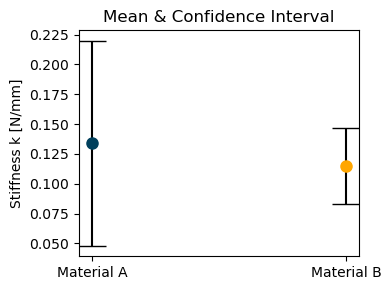

In [15]:
# Plot the confidence intervals
plt.figure(figsize=(4, 3))

for i, material_name in enumerate(confidence_intervals.keys()):
    lower_bound, upper_bound = confidence_intervals[material_name]
    mean_value = means[material_name]
    
    # Plot the confidence interval as an error bar
    plt.errorbar(material_name, mean_value, 
                 yerr=[[mean_value - lower_bound], [upper_bound - mean_value]], 
                 fmt='o', color=colors[i], ecolor='black', capsize=10, markersize=8)

# Customize the plot
plt.title('Mean & Confidence Interval')
plt.ylabel('Stiffness k [N/mm]')
plt.tight_layout()
plt.show()


### Interpreting the Confidence Intervals

The plot of the **mean stiffness** and **confidence intervals** provides valuable insights into the data, but it has limitations. Here's what it tells us and what it does not:

#### What the Confidence Intervals Tell Us

1. **Range of the Population Mean**:
   The confidence intervals show the range within which we expect the true population mean stiffness to lie, with 95% confidence. The length of the interval gives us an idea of the precision of the sample mean:
   - A **narrow interval** indicates high precision, meaning the sample mean is likely a good estimate of the population mean.
   - A **wider interval** suggests more variability in the sample and less confidence in the precision of the sample mean.

2. **Potential Overlap**:
   When comparing the confidence intervals of two materials:
   - If the intervals **do not overlap**, this suggests that the population means of the two materials might be significantly different.
   - If the intervals **overlap**, it indicates that the true means of the two materials could be similar, but this is not definitive.

#### What the Confidence Intervals Do Not Tell Us

1. **Statistical Significance**:
   While overlapping or non-overlapping confidence intervals give us a rough idea about the similarity or difference between the materials, this is not equivalent to a formal hypothesis test. Confidence intervals alone cannot determine whether the observed difference in means is statistically significant. For that, we need to perform a **hypothesis test**, which will provide a p-value indicating the likelihood that the observed differences are due to chance.

2. **Direction of the Difference**:
   The confidence intervals do not tell us **in which direction** one material might differ from the other in terms of stiffness. They only give us the range of possible values for the true mean of each material.

To make a more definitive statement about whether the two materials (boxes of rubber bands) have significantly different stiffness values, we need to conduct a **hypothesis test**. This will allow us to statistically evaluate whether the differences observed in the sample means are likely to reflect true differences in the population means, or if they could have occurred by random chance.


## Hypothesis Testing

**Hypothesis testing** is a statistical method used to make inferences about a population based on sample data. The goal is to determine whether there is enough evidence in the sample to support a specific claim (hypothesis) about the population.

In hypothesis testing, we formulate two competing hypotheses:
- **Null Hypothesis (H₀)**: Assumes that there is no effect or no difference. In our case, this would mean that the two boxes of rubber bands have the same mean stiffness.
- **Alternative Hypothesis (H₁)**: Assumes that there is an effect or a difference. For our example, the alternative hypothesis would be that the mean stiffness of the rubber bands in the two boxes is different.

We then use sample data to determine whether to reject or fail to reject the null hypothesis. This decision is based on the **p-value**, which measures the probability of observing the data (or something more extreme) if the null hypothesis is true.


### Hypothesis Testing in Material Testing

In the context of our material testing, we are comparing the stiffness of rubber bands from two boxes (Box A and Box B) to determine whether they are made of the same material.

#### Formulating the Hypotheses

- **Null Hypothesis (H₀)**: The mean stiffness of the rubber bands in Box A is equal to the mean stiffness in Box B.

  $$
  H₀: \mu_A = \mu_B
  $$

- **Alternative Hypothesis (H₁)**: The mean stiffness of the rubber bands in Box A is not equal to the mean stiffness in Box B.

  $$
  H₁: \mu_A \neq \mu_B
  $$

The goal is to test whether the observed difference in sample means is statistically significant, or if it could have occurred by chance due to sampling variability.

#### Test Statistic

To test the hypotheses, we calculate a **test statistic** using a **t-test**, which compares the means of two independent samples and adjusts for the variability within each sample.

#### p-Value and Decision

The **p-value** is the probability of observing the data (or something more extreme) if the null hypothesis is true. Based on the p-value, we make a decision:
- If the p-value is **less than** a chosen significance level (typically α = 0.05), we **reject the null hypothesis**. This means there is evidence to suggest that the stiffness of rubber bands in the two boxes is different.
- If the p-value is **greater than** 0.05, we **fail to reject the null hypothesis**, meaning the data does not provide strong evidence of a difference.

#### Significance Level (α)

The **significance level** (α) is the threshold used to decide whether to reject the null hypothesis. Common choices for α are 0.05 or 0.01, representing a 5% or 1% chance of rejecting the null hypothesis when it is actually true (a Type I error). In this analysis, we will use α = 0.05.


#### Relationship Between Confidence Level and Significance Level

In our analysis, the **confidence level** and **significance level** are closely related and complementary. Specifically, the confidence level is equal to:

$$
\text{Confidence Level} = 1 - \text{Significance Level}
$$

In this case, we are using a **significance level (α)** of 0.05, meaning we allow a 5% chance of making a **Type I error**—falsely concluding that the stiffness between the two boxes is different when it is not.

The corresponding **confidence level** is 95%, meaning that if we were to take repeated samples and calculate confidence intervals, 95% of those intervals would contain the true mean stiffness of the rubber bands. Thus, while the significance level sets the threshold for rejecting the null hypothesis, the confidence level reflects the reliability of our interval estimates.


### Performing a t-test for Comparing Mean Stiffness

In this code, we conduct an independent two-sample **t-test** to compare the mean stiffness of rubber bands from two materials (Material A and Material B). The t-test helps us determine whether there is a statistically significant difference between the mean stiffness values of the two materials.

#### Key Components:

- **`stats.ttest_ind()`**: This function performs an independent two-sample t-test. We use **Welch’s t-test** by setting `equal_var=False`, as it does not assume that the two samples have equal variances.
  - The function compares the 'stiffness' values from both materials after removing any missing values with `.dropna()`.
  
- **T-statistic**: The t-statistic measures the difference between the sample means in relation to the variability in the samples. A larger t-statistic indicates a larger difference between the sample means.

- **P-value**: The p-value tells us the probability of obtaining the observed difference between the means (or a more extreme one) if the null hypothesis is true. A lower p-value suggests stronger evidence against the null hypothesis.

- **Decision Rule**: We compare the p-value to the significance level (α = 0.05):
  - If the **p-value is less than 0.05**, we **reject the null hypothesis**. This means there is a statistically significant difference between the mean stiffness of the two materials.
  - If the **p-value is greater than or equal to 0.05**, we **fail to reject the null hypothesis**, meaning there is no strong evidence of a difference between the two materials.


In [16]:
# Perform independent two-sample t-test
t_stat, p_value = stats.ttest_ind(
    data_frames['Material A']['stiffness'].dropna(),
    data_frames['Material B']['stiffness'].dropna(),
    equal_var=False  # Use Welch's t-test by setting equal variance to False
)

# Print the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Decision based on significance level (alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two materials.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the two materials.")


T-statistic: 0.4174
P-value: 0.6783
Fail to reject the null hypothesis: No significant difference between the two materials.


### Interpreting the t-test in the Context of Rubber Bands

In the context of our rubber band experiment, the t-test helps us determine whether the observed difference in stiffness between the rubber bands from **Box A** and **Box B** is likely to reflect a true difference in the materials used in each box or if the difference could simply be due to random variation in the samples.

- If the **p-value is less than 0.05**, we reject the null hypothesis, suggesting that the two boxes contain rubber bands with significantly different stiffness. This would mean that the difference we observe in the sample stiffness is unlikely to be due to chance and may indicate that the rubber bands in the two boxes are made from different materials.

- If the **p-value is greater than or equal to 0.05**, we fail to reject the null hypothesis, meaning that the difference in sample stiffness could easily have arisen by chance due to sampling variability. In this case, we have no strong evidence to conclude that the rubber bands in the two boxes are different.

Thus, the t-test allows us to make a more informed judgment about whether the stiffness of the rubber bands from the two boxes is genuinely different or simply appears different because of random fluctuations in the sample data.


<h2 style="color:red;">WARNING</h2>

While our analysis assumed that the **stiffness** of the materials is normally distributed for simplicity, in reality, elastic properties such as stiffness are often **log-normally distributed**. This is because material properties are influenced by multiple factors that can lead to a skewed distribution, especially when there are variations in the microstructure or processing conditions.

In a **log-normal distribution**, the natural logarithm of the property follows a normal distribution, which means that the property itself is positively skewed, with most values clustering near the lower end and a few high values stretching the tail.

### Consequences of Assuming a Log-Normal Distribution

Had we modeled the stiffness as log-normally distributed, the following changes would have been necessary:

1. **Mean and Standard Deviation**:
   - The mean and standard deviation would have been computed on the **log-transformed data**.
   - The mean and standard deviation on the original (non-log) scale would then be calculated using transformation formulas, which account for the skewed nature of the distribution.
   
2. **Standard Error**:
   - The standard error would also be computed on the log-transformed data, which adjusts for the skewness. Interpreting the precision of the mean estimate would then require transforming the result back to the original scale.

3. **Confidence Interval**:
   - The confidence intervals would be calculated for the log-transformed data, and then exponentiated back to the original scale. As a result, the confidence intervals would be **asymmetric** on the original scale, with the upper bound farther from the mean than the lower bound, reflecting the skewed nature of the log-normal distribution.

4. **Hypothesis Testing**:
   - A **t-test** could still be applied after log-transforming the data.